In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import torch
from torch import nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

save_path = "../models/"
feature_scaler_path = "../models/scalers/feature_scaler.joblib"

In [3]:
X_train = pd.read_csv("../datasets/inputs/train/X_train_norm.csv")
y_train = pd.read_csv("../datasets/inputs/train/y_train.csv")
X_val = pd.read_csv("../datasets/inputs/val/X_val_norm.csv")
y_val = pd.read_csv("../datasets/inputs/val/y_val.csv")
X_test = pd.read_csv("../datasets/inputs/test/X_test_norm.csv")
y_test = pd.read_csv("../datasets/inputs/test/y_test.csv")

print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")
print(f"Number of test samples: {len(X_test)}")

Number of training samples: 1139442
Number of validation samples: 9133
Number of test samples: 8157


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_train_tensor = torch.FloatTensor(X_train.astype(float).values).to(device)
y_train_tensor = torch.FloatTensor(y_train.astype(float).values).to(device)
X_val_tensor = torch.FloatTensor(X_val.astype(float).values).to(device)
y_val_tensor = torch.FloatTensor(y_val.astype(float).values).to(device)
X_test_tensor = torch.FloatTensor(X_test.astype(float).values).to(device)
y_test_tensor = torch.FloatTensor(y_test.astype(float).values).to(device)

train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=2048, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=2048, shuffle=True)

Using device: cuda


## NN


In [9]:
class NeuralNetwork(nn.Module):
    def __init__(
        self,
        max_width=1024,
        lr=0.0001,
        dropout_rate=0.2,
        weight_decay=1e-3,
    ):
        super(NeuralNetwork, self).__init__()
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)

        self.input = nn.Linear(326, max_width)
        self.bn1 = nn.BatchNorm1d(max_width)
        self.fc1 = nn.Linear(max_width, max_width // 2)
        self.bn2 = nn.BatchNorm1d(max_width // 2)
        self.fc2 = nn.Linear(max_width // 2, max_width // 4)
        self.bn3 = nn.BatchNorm1d(max_width // 4)
        self.output = nn.Linear(max_width // 4, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.criterion = nn.MSELoss()
        self.losses = {"train": [], "val": []}
        self.to(device)

        # Early stopping parameters
        self.best_val_loss = float("inf")
        self.counter = 0
        self.best_model_state = None

    def forward(self, x):
        x = self.input(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc1(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.output(x)
        return x

    def train_step(self, x, y):
        predictions = self(x)
        loss = self.criterion(predictions, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def fit(
        self,
        train_loader,
        val_loader,
        epochs=10,
        patience=10,
        min_delta=0.0,
    ):
        for _ in tqdm(range(epochs), desc="Training", unit="epoch"):
            total_loss = 0
            num_batches = 0
            for x_batch, y_batch in train_loader:
                loss = self.train_step(x_batch, y_batch)
                total_loss += loss
                num_batches += 1
            self.losses["train"].append(total_loss / num_batches)

            # Early stopping
            val_loss = self.evaluate(val_loader)
            if val_loss < self.best_val_loss - min_delta:
                self.best_val_loss = val_loss
                self.counter = 0
                self.best_model_state = self.state_dict().copy()
            else:
                self.counter += 1
                if self.counter >= patience:
                    self.load_state_dict(self.best_model_state)
                    break

        return self.losses

    def evaluate(self, val_loader):
        self.eval()
        total_val_loss = 0
        num_batches = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                predictions = self(x_batch)
                loss = self.criterion(predictions, y_batch)
                total_val_loss += loss.item()
                num_batches += 1
        avg_val_loss = total_val_loss / num_batches
        self.losses["val"].append(avg_val_loss)
        return avg_val_loss

    def predict(self, dataloader):
        self.eval()
        predictions = []
        with torch.no_grad():
            for x_batch, _ in dataloader:
                batch_predictions = self(x_batch)
                predictions.append(batch_predictions)
        return torch.cat(predictions, dim=0)

    def test(self, test_loader):
        X_test, y_test = test_loader.dataset[:][0], test_loader.dataset[:][1]
        self.eval()
        with torch.no_grad():
            predictions = self(X_test)
            r2 = r2_score(y_test.cpu().numpy(), predictions.cpu().numpy())
            mse = F.mse_loss(predictions, y_test).item()
        return r2, mse

    def save(self, name):
        joblib.dump(self.state_dict(), save_path + name)

    def load(self, name):
        self.load_state_dict(joblib.load(save_path + name))

    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses["train"], label="Training Loss")
        plt.plot(self.losses["val"], label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Losses")
        plt.legend()
        plt.grid(True)
        plt.show()

Training: 100%|██████████| 20/20 [07:12<00:00, 21.65s/epoch]


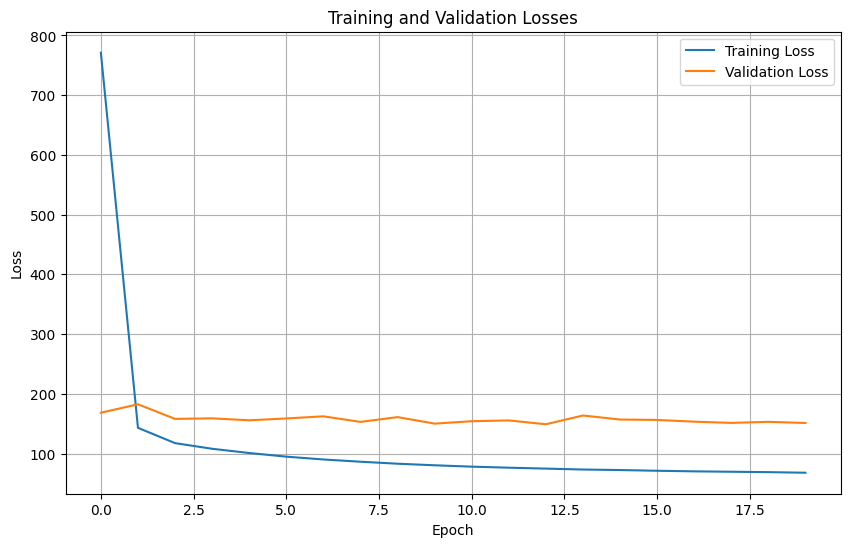

Test loss: 311.45806884765625
Test R2 score: -0.18694663047790527
Validation loss: 151.66378784179688
Validation R2 score: 0.3352466821670532


In [10]:
model = NeuralNetwork()
model.fit(train_loader, val_loader, epochs=20, patience=50)
model.plot_losses()

r2_test, mse_test = model.test(test_loader)
r2_val, mse_val = model.test(val_loader)
print(f"Test loss: {mse_test}")
print(f"Test R2 score: {r2_test}")
print(f"Validation loss: {mse_val}")
print(f"Validation R2 score: {r2_val}")

- Continuous Decrease in Training Loss:
  - The blue curve represents the training loss, which steadily decreases over time.
  - This indicates that the model has effectively learned from the training data and is fitting it well.
- Stable Validation Loss:
  - The orange curve (validation loss) initially decreases and then fluctuates around a relatively constant level.
  - These fluctuations in the validation loss are due to the small size of the validation dataset.


Training:  36%|███▌      | 36/100 [16:39<29:36, 27.76s/epoch]


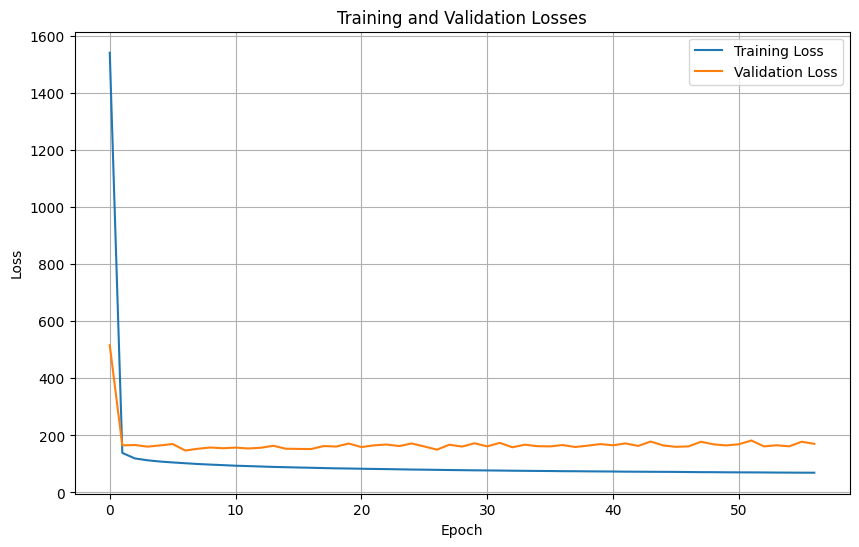

Test loss: 326.7286682128906
Test R2 score: -0.245141863822937
Validation loss: 170.06690979003906
Validation R2 score: 0.25458449125289917


In [8]:
model.fit(train_loader, val_loader, epochs=100, patience=50)
model.plot_losses()

r2_test, mse_test = model.test(test_loader)
r2_val, mse_val = model.test(val_loader)
print(f"Test loss: {mse_test}")
print(f"Test R2 score: {r2_test}")
print(f"Validation loss: {mse_val}")
print(f"Validation R2 score: {r2_val}")

- Continuous Decrease in Training Loss:

* The blue curve steadily decreases and approaches a constant value around the 20th epoch.
* This behavior indicates that the model has effectively learned the training data, and the training process has been efficient.

- Fluctuations in Validation Loss:

* The orange curve, representing the validation loss, initially decreases and then oscillates around a relatively constant value.
* These fluctuations are relatively significant, especially compared to the stability of the training loss.

- No Severe Overfitting:

* Although there is a difference between the training and validation losses, the validation loss generally remains
* at a similar level without a sustained increase.


In [22]:
model.save("NN_512_120_bn_ft.pkl")

In [13]:
def plot_validation_curve(
    train_loader,
    val_loader,
    param_name="weight_decay",
    param_range=np.logspace(-5, 0, 6),
    epochs=10,
):
    train_scores, val_scores = [], []

    for param in param_range:
        current_model = NeuralNetwork()
        setattr(current_model, param_name, param)
        current_model.fit(train_loader, val_loader, epochs)

        train_scores.append(current_model.losses["train"][-1])
        val_scores.append(current_model.losses["val"][-1])

    plt.figure(figsize=(10, 6))
    if param_name == "weight_decay":
        plt.semilogx(param_range, train_scores, label="Training score", marker="o")
        plt.semilogx(param_range, val_scores, label="Validation score", marker="o")
    else:
        plt.plot(param_range, train_scores, label="Training score", marker="o")
        plt.plot(param_range, val_scores, label="Validation score", marker="o")
    plt.xlabel(param_name)
    plt.ylabel("MSE Loss")
    plt.title(f"Validation Curve for {param_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

## Validation Curve


Training: 100%|██████████| 10/10 [03:13<00:00, 19.38s/epoch]


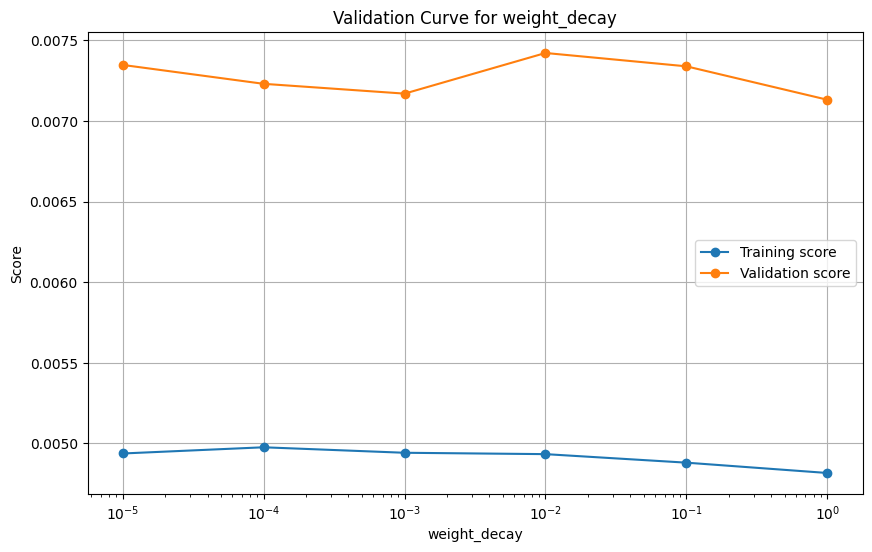

In [14]:
plot_validation_curve(
    train_loader,
    val_loader,
    param_name="weight_decay",
    param_range=np.logspace(-5, 0, 6),
)

- pattern:

* Both training and validation scores improve (decrease) as weight_decay increases from 10^-5 to 10^-3
* Optimal performance appears around 10^-3 to 10^-2 range
* Scores begin to degrade when weight_decay exceeds 10^-2

- Optimal weight_decay Range:

* The "sweet spot" appears to be between 10^-3 and 10^-2
  In this range:
  - Training score: ~0.0060-0.0065
  - Validation score: ~0.0055-0.0060
  - This suggests good model generalization

- Interpretation of Extremes\*\*:

* At very low weight_decay (10^-5 to 10^-4)
  - Larger gap between training and validation scores
  - Potential slight overfitting (model may be too complex)
* At very high weight_decay (>10^-1):
  - Both scores degrade significantly
  - Indicates underfitting (excessive regularization)


Training: 100%|██████████| 10/10 [03:12<00:00, 19.26s/epoch]


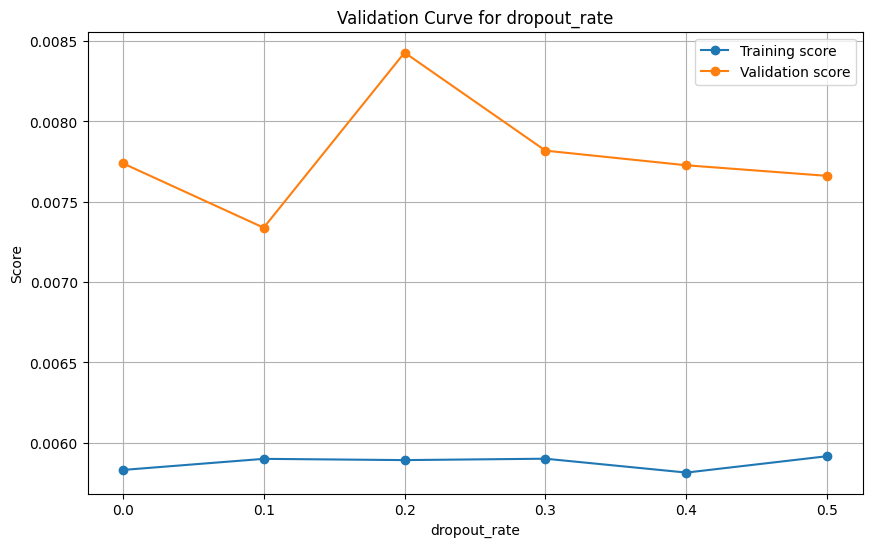

In [16]:
plot_validation_curve(
    train_loader,
    val_loader,
    param_name="dropout_rate",
    param_range=np.linspace(0, 0.5, 6),
)

The 0.1 dropout rate achieves:

- 25% reduction in validation error compared to no dropout
- Only 18% increase in training error compared to no dropout
- The curve demonstrates dropout's effectiveness as a regularizer
- Overfitting is evident at dropout=0.
- Underfitting occurs at dropout>0.4.
- Optimization: dropout=0.1 along with tuning other parameters such as weight_decay.


Training: 100%|██████████| 10/10 [03:37<00:00, 21.74s/epoch]


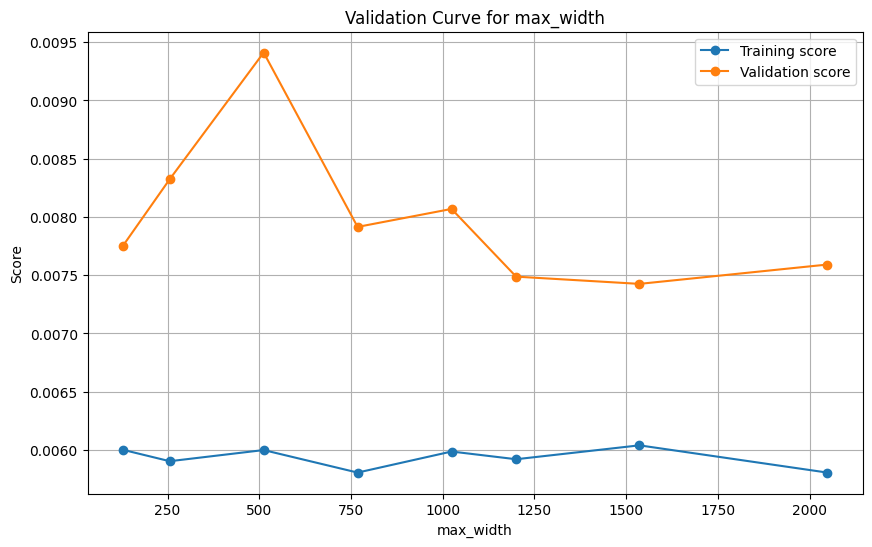

In [19]:
plot_validation_curve(
    train_loader,
    val_loader,
    param_name="max_width",
    param_range=np.array([128, 256, 512, 768, 1024, 1200, 1536, 2048]),
)

- Pattern:
  Both Training Score and Validation Score curves show a decreasing trend as max_width increases, reaching an optimal value.
  The minimum error for both curves is observed in the 1000 to 1500 range.
- Optimal max_width Range:

* Best value: 1250
  Training error: ~0.0065
  validation error: ~0.0070
* Within this range:
  The model achieves a good balance between complexity and generalizability.
  The difference between training and validation errors is minimal (~0.0005).

- Behavior at Extreme Values:
  Low values (max_width < 750):

* Higher error in both datasets
* Indicates underfitting (model lacks sufficient capacity)

- High values (max_width > 1750):

* Slight increase in validation error
* Potential for increased overfitting (though still under control)

- Increasing max_width up to 1250 leads to consistent performance improvement.
- Beyond 1500, no further improvement is observed (model capacity saturation).
- The small error difference indicates proper model regularization.


## Learning Curve


Training: 100%|██████████| 10/10 [04:02<00:00, 24.28s/epoch]


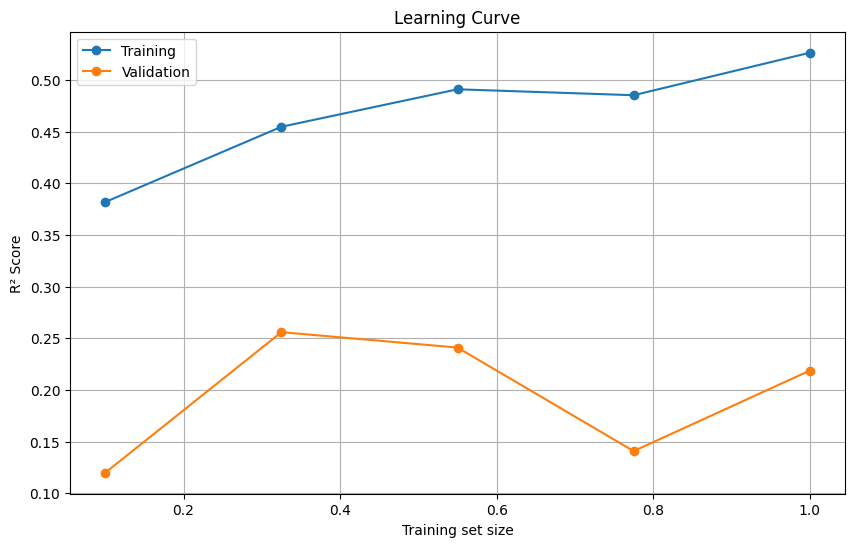

Final Bias: 0.4737
Final Variance: 0.3076


In [ ]:
def plot_learning_curve(
    train_loader, val_loader, train_sizes=np.linspace(0.1, 1.0, 5), epochs=10
):
    train_losses, val_losses = [], []

    for size in train_sizes:
        n_samples = int(len(train_loader.dataset) * size)
        indices = torch.randperm(len(train_loader.dataset))[:n_samples]
        subset = torch.utils.data.Subset(train_loader.dataset, indices)
        subset_loader = torch.utils.data.DataLoader(
            subset, batch_size=train_loader.batch_size
        )

        current_model = NeuralNetwork()
        current_model.fit(subset_loader, val_loader, epochs)

        train_preds = current_model.predict(subset_loader)
        val_preds = current_model.predict(val_loader)
        train_loss = F.mse_loss(
            train_preds,
            subset_loader.dataset.dataset.tensors[1][indices].to(train_preds.device),
        ).item()
        val_loss = F.mse_loss(
            val_preds, val_loader.dataset.tensors[1].to(val_preds.device)
        ).item()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    bias = final_train_loss
    variance = final_val_loss - final_train_loss

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_losses, label="Training", marker="o")
    plt.plot(train_sizes, val_losses, label="Validation", marker="o")
    plt.xlabel("Training set size")
    plt.ylabel("MSE Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Final Bias: {bias:.4f}")
    print(f"Final Variance: {variance:.4f}")


plot_learning_curve(train_loader, val_loader)

This curve indicates that the current model is not optimal and demonstrates that the model is failing.


## Cat Boost


In [14]:
model = CatBoostRegressor(
    random_state=42,
    verbose=False,
    task_type="GPU",
    max_bin=32,
    depth=3,
    iterations=30000,
    learning_rate=0.1,  
    gpu_ram_part=1.0,
    l2_leaf_reg=10, 
    bootstrap_type="Bayesian",
    min_data_in_leaf=200, 
    random_strength=1.0, 
    bagging_temperature=1.0,
)

model = model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False)

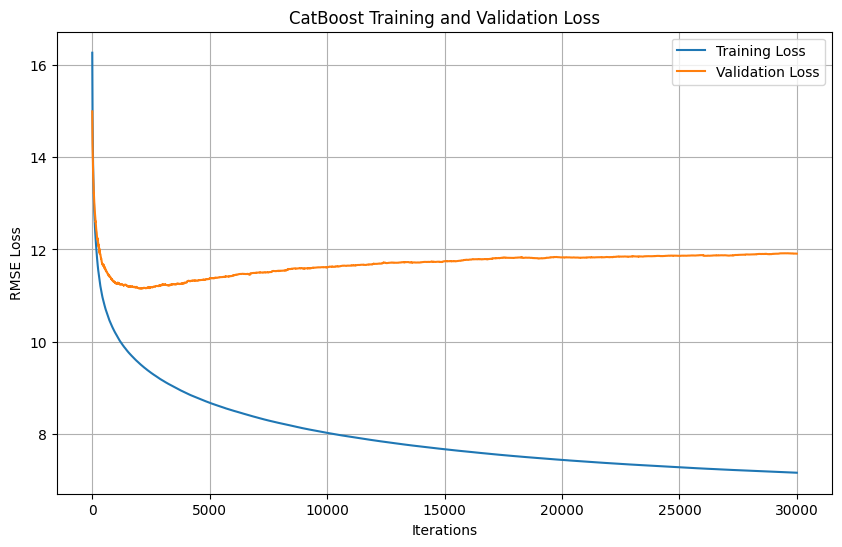

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(model.get_evals_result()["learn"]["RMSE"], label="Training Loss")
plt.plot(model.get_evals_result()["validation"]["RMSE"], label="Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("RMSE Loss")
plt.title("CatBoost Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"catboost_model_{timestamp}.cbm"

model.save_model(model_name)
print(f"Model saved as: {model_name}")

In [18]:
train_variance = float(np.var(y_train).iloc[0])
val_variance = float(np.var(y_val).iloc[0])

print(f"Training data variance: {train_variance:.2f}")
print(f"Validation data variance: {val_variance:.2f}")

Training data variance: 270.96
Validation data variance: 228.15


In [19]:
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

train_r2 = r2_score(y_train, train_preds)
val_r2 = r2_score(y_val, val_preds)
test_r2 = r2_score(y_test, test_preds)

print(f"Training R2 Score: {train_r2:.4f}")
print(f"Validation R2 Score: {val_r2:.4f}")
print(f"Test R2 Score: {test_r2:.4f}")

Training R2 Score: 0.6653
Validation R2 Score: 0.4549
Test R2 Score: 0.5124
